In [25]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from typing import Tuple
from torch.special import gammaln
import os

In [26]:
DEVICE = "cpu" # NOTE MacM2 processor is mps , cpu should be default  , if CUDA support and installed use cuda instead
SEED=3012024
EPOCHS = 10
torch.manual_seed(SEED)

In [27]:
def recompute_mean_var(mu1, mu2, log_var1, log_var2):
        # var^(-1)
        # print(mu1.shape, mu2.shape )
        var1 = (-log_var1).exp() 
        var2 = (-log_var2).exp()

        mu = (mu1 * var1 + mu2 * var2)/(var1 + var2)
        log_var = -torch.log(var1 + var2)
        return mu, log_var

## Models

## Bernoulli and Continuous

In [28]:
class VAE(nn.Module):
    def __init__(self, hidden_dims, data_dim=784, device=DEVICE):
        super().__init__()
        assert len(hidden_dims) == 5, "Insufficiently number of dimensions!"
        self.data_dim = data_dim
        self.device = device
        # define IO
        self.in_layer = nn.Linear(data_dim, hidden_dims[0])
        self.out_layer = nn.Linear(hidden_dims[-1], data_dim)
        # hidden layer
        self.enc_h = nn.Linear(hidden_dims[0], hidden_dims[1])
        # define hidden and latent
        self.enc_mu = nn.Linear(hidden_dims[1], hidden_dims[2])
        self.enc_sigma = nn.Linear(hidden_dims[1], hidden_dims[2])
        # hidden layer decoder
        self.dec_h = nn.Linear(hidden_dims[2], hidden_dims[-2])
        self.dec_layer = nn.Linear(hidden_dims[-2], hidden_dims[-1])
        self.to(device)
        
    def encode(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        h1 = F.relu(self.in_layer(x))
        h2 = F.relu(self.enc_h(h1))
        return self.enc_mu(h2), self.enc_sigma(h2)

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        h3 = F.relu(self.dec_h(z))
        h4 = F.relu(self.dec_layer(h3))
        return torch.sigmoid(self.out_layer(h4))

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        mu, logvar = self.encode(x.view(-1, self.data_dim))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

### Beta

In [29]:

## using the provided resource as base architecture
class BetaVAE(nn.Module):
    def __init__(self, hidden_dims, data_dim=784, device=DEVICE):
        super().__init__()
        # assert len(hidden_dims) == 5, "Insufficiently number of dimensions!"
        self.data_dim = data_dim
        self.device = device

        dim_enc, dim_mu_in, dim_mu_out, dim_dec, dim_dec, dim_alpha, dim_out = hidden_dims

        # define IO
        self.in_layer = nn.Linear(data_dim, dim_enc)

        # hidden layer
        self.enc_h = nn.Linear(dim_enc, dim_mu_in)
        # define hidden and latent
        self.enc_mu = nn.Linear(dim_mu_in, dim_mu_out)
        self.enc_sigma = nn.Linear(dim_mu_in, dim_mu_out)
        # hidden layer decoder
        self.dec_h = nn.Linear(dim_mu_out, dim_dec)
        self.dec_layer = nn.Linear(dim_dec, dim_alpha)
        self.alpha_layer1 = nn.Linear(dim_alpha, dim_out)
        self.alpha_layer2 = nn.Linear(dim_out, data_dim)

        self.beta_layer1 = nn.Linear(dim_alpha,dim_out)
        self.beta_layer2 = nn.Linear(dim_out, data_dim)

        self.to(device)
        
    def encode(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        h1 = F.relu(self.in_layer(x))
        h2 = F.relu(self.enc_h(h1))
        return self.enc_mu(h2), self.enc_sigma(h2)

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        h3 = F.relu(self.dec_h(z))
        h4 = F.relu(self.dec_layer(h3))
        #torch.sigmoid(self.out_layer(h4))

        # layers for alpha
        alpha = F.relu(self.alpha_layer1(h4))
        alpha = F.sigmoid(self.alpha_layer2(alpha))

        # layers for beta
        beta = F.relu(self.beta_layer1(h4))
        beta = F.sigmoid(self.beta_layer2(beta))

        return alpha, beta

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        mu, logvar = self.encode(x.view(-1, self.data_dim))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

### Ladder VAE

In [30]:

class Encoder(nn.Module):
    def __init__(self, dim):
        super().__init__()
        in_dim, hid1_dim, hid2_dim, mu_dim = dim
        # self.in_layer = nn.Linear(data_dim, hidden_dims[0])
        # self.enc_h = nn.Linear(hidden_dims[0], data_dim)
        # self.enc_mu = nn.Linear(data_dim, hidden_dims[2])
        # self.enc_sigma = nn.Linear(data_dim, hidden_dims[2])
        self.in_layer = nn.Linear(in_dim, hid1_dim)
        self.enc_h = nn.Linear(hid1_dim, hid2_dim)
        self.enc_mu = nn.Linear(hid2_dim, mu_dim)
        self.enc_sigma = nn.Linear(hid2_dim, mu_dim)

    def forward(self, x):
        h1 = F.relu(self.in_layer(x))
        h2 = F.relu(self.enc_h(h1))
        return h2, self.enc_mu(h2), F.softplus(self.enc_sigma(h2))
    
class Ladder(nn.Module):
    def __init__(self, dim):
        super().__init__()
        in_dim, hid1_dim, hid2_dim, mu_dim = dim

        # self.in_layer = nn.Linear(hidden_dims[2], hidden_dims[-2])
        # self.enc_h = nn.Linear(hidden_dims[-2], hidden_dims[2])
        # self.enc_mu = nn.Linear(hidden_dims[2], hidden_dims[2])
        # self.enc_sigma = nn.Linear(hidden_dims[2], hidden_dims[2])
        self.in_layer = nn.Linear(in_dim, hid1_dim)
        self.enc_h = nn.Linear(hid1_dim, hid2_dim)
        self.enc_mu = nn.Linear(hid2_dim, mu_dim)
        self.enc_sigma = nn.Linear(hid2_dim, mu_dim)
    
    def forward(self, x):
        h1 = F.relu(self.in_layer(x))
        h2 = F.relu(self.enc_h(h1))
        return self.enc_mu(h2), F.softplus(self.enc_sigma(h2))

## using the provided resource as base architecture
class LadderVAE(nn.Module):
    def __init__(self, hidden_dims, ladder_dims, encoder_dims, data_dim=784, device=DEVICE):
        super().__init__()
        assert len(hidden_dims) == 5, "Insufficiently number of dimensions!"
        self.data_dim = data_dim
        self.device = device
        # define IO
        self.out_layer = nn.Linear(hidden_dims[-1], data_dim)
        self.encoders = nn.Sequential(*[Encoder(dim) for dim in encoder_dims])

        self.ladders = nn.Sequential(*[Ladder(dim) for dim in ladder_dims])
        
        # hidden layer
        # define hidden and latent
        # hidden layer decoder
        self.dec_h = nn.Linear(hidden_dims[2], hidden_dims[-2])
        self.dec_layer = nn.Linear(hidden_dims[-2], hidden_dims[-1])

        self.to(device)
        
    def encode(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        params = []
        for encoder in self.encoders:
            x, mu, sigma = encoder(x)
            params.append((mu, sigma))
        return params

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z: torch.Tensor, params) -> torch.Tensor:
        kld = 0
        params.reverse()
        for i, ladder in enumerate(self.ladders):
            mu_p, logvar_p = ladder(z)
            mu_q, logvar_q = params[i]
            mu, logvar = recompute_mean_var(mu_q, mu_p, logvar_q, logvar_p)
            z  = self.reparameterize(mu, logvar)
            kld += self.compute_kl_divergence(mu, logvar, mu_q, logvar_q)
        h3 = F.relu(self.dec_h(z))
        h4 = F.relu(self.dec_layer(h3))
        return torch.sigmoid(self.out_layer(h4)), kld
    
    def sample(self, z):

        for ladder_block in self.ladders:
            mu, log_var = ladder_block(z)
            z = self.reparameterize(mu, log_var)

        h3 = F.relu(self.dec_h(z))
        h4 = F.relu(self.dec_layer(h3))
        return torch.sigmoid(self.out_layer(h4))

    def compute_kl_divergence(self, mu_q, log_var_q, mu_p, log_var_p):

        # mu_q, log_var_q = q_params
        # mu_p, log_var_p = p_params
        

        kl = (log_var_p - log_var_q) + (log_var_q.exp() + (mu_q - mu_p)**2)/(2 * log_var_p.exp()) - 0.5
        kl = torch.sum(kl, dim = -1)
        return kl
        return -1/2 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())


    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        params = self.encode(x.view(-1, self.data_dim))
        mu, logvar = params.pop()
        self.params = params
        z = self.reparameterize(mu, logvar)
        return self.decode(z, params), mu, logvar

# Common functions

In [31]:
def train(loss, optimizer, model, epoch: int, train_loader: torch.utils.data.DataLoader, log_interval: int=25) -> list:
    model.train()
    train_loss = 0.
    train_loss_vals = []
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(model.device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(x)
        loss_val, ce, kld = loss(recon_batch, x, mu, logvar)
        loss_val.backward()
        train_loss += loss_val.item()
        train_loss_vals.append(loss_val.item())
        optimizer.step()
        if batch_idx % log_interval == 0:
            print(f"Train epoch={epoch} [{batch_idx*len(x)}/{len(train_loader.dataset)}]\t loss={loss_val.item() / len(x)}")
            print(f"BCE={ce} KLD={kld}")
    print(f"===> epoch={epoch} avrg.loss={train_loss/len(train_loader.dataset)}")
    return train_loss_vals

In [ ]:
def test(loss, model, epoch: int, test_loader: torch.utils.data.DataLoader, fn = None) -> list:
    model.eval()
    test_loss = 0.
    test_loss_vals = []
    with torch.no_grad():
        for i, (x, _) in enumerate(test_loader):
            x = x.to(model.device)
            recon_batch, mu, logvar = model(x)
            recon_batch = recon_batch if fn is None else fn(recon_batch)

            test_loss_val, ce, kld = loss(recon_batch, x, mu, logvar)
            test_loss += test_loss_val.item()
            test_loss_vals.append(test_loss_val.item())
            # if i == 0: # TODO: do we want to persist images here?
            #     n = min(data.size(0), 8)
            #     comparison = torch.cat([x[:n], ])
    test_loss /= len(test_loader.dataset)
    print(f"===> Test loss={test_loss}")
    return test_loss_vals

In [33]:
# lets use torch datasets with our data
class DatasetWrapper(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [34]:
# Download csv files
# %pip install gdown
import gdown
train_filename = 'mnist_train.csv'
test_filename = 'mnist_test.csv'

if not(os.path.exists(train_filename) and os.path.exists(test_filename)):
    train_id = '1UYlB8NsA2K8jZkDVlYo7_S-K5d66fwsZ'
    test_id = '1_t_RPAnMZnLBw3jbV2eTX1Gy3qP8vm6T'
    base_url = 'https://drive.google.com/uc?id='
    gdown.download(base_url + train_id, train_filename, quiet=False)
    gdown.download(base_url + test_id, test_filename, quiet=False)

In [35]:
mnist_train = np.loadtxt("mnist_train.csv", delimiter=",", dtype=np.float32, skiprows=1)
mnist_test = np.loadtxt("mnist_test.csv", delimiter=",", dtype=np.float32, skiprows=1)
train_labels = mnist_train[:,0]
train_data = mnist_train[:,1:] / 255
test_labels = mnist_test[:,0]
test_data = mnist_test[:,1:] / 255 # NOTE: don't forget to standardize

train_data.shape, test_data.shape

train_ds = DatasetWrapper(train_data, train_labels)
test_ds = DatasetWrapper(test_data, test_labels)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=128, shuffle=True)

In [36]:
def sumlogC(x , eps = 1e-5):
    # From https://github.com/Robert-Aduviri/Continuous-Bernoulli-VAE/tree/master
    '''
    Numerically stable implementation of 
    sum of logarithm of Continous Bernoulli
    constant C, using Taylor 2nd degree approximation
        
    Parameter
    ----------
    x : Tensor of dimensions (batch_size, dim)
        x takes values in (0,1)
    ''' 
    x = torch.clamp(x, eps, 1.-eps) 
    mask = torch.abs(x - 0.5).ge(eps)
    far = torch.masked_select(x, mask)
    close = torch.masked_select(x, ~mask)
    far_values =  torch.log( (torch.log(1. - far) - torch.log(far)).div(1. - 2. * far) )
    close_values = torch.log(torch.tensor((2.))) + torch.log(1. + torch.pow( 1. - 2. * close, 2)/3. )
    return far_values.sum() + close_values.sum()

In [37]:
def run_train_and_plot(model, loss):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    train_loss_vals_total = []
    test_loss_vals_total = []
    for e in range(1, EPOCHS+1):
        train_loss_vals = train(loss, optimizer, model, epoch=e, train_loader=train_loader)
        test_loss_vals = test(loss, model, epoch=e, test_loader=test_loader)
        train_loss_vals_total.append(train_loss_vals)
        test_loss_vals_total.append(test_loss_vals)
    return train_loss_vals_total, test_loss_vals_total


In [38]:
def plot_losses(train_loss_vals_total, test_loss_vals_total, filename, subtitle = "BCE+KLD"):
    plt.plot(np.arange(1, EPOCHS+1), [np.mean(ls) for ls in train_loss_vals_total], lw=2.5, label="train")
    plt.plot(np.arange(1, EPOCHS+1), [np.mean(ls) for ls in test_loss_vals_total], lw=2.5, label="test")
    plt.xlabel("epoch")
    plt.ylabel(f"loss\n {subtitle}")
    # plt.yscale("log")
    plt.title("VAE avrg. training loss per epoch")
    plt.legend()
    plt.savefig(filename)
    plt.show()

In [54]:
def measure_sq_mean_diff(models):
    diffs = [[] for _ in models]
    for img in test_data:
        img = torch.tensor(img)
        for i, model in enumerate(models):
            diffs[i].append(torch.mean((img - model(img)) ** 2).item())
    return [np.mean(diff) for diff in diffs]

In [62]:
# Calc. likelihood for comparison
def calc_likelihood(model, loss, n_samples, fn = None):
    
    with torch.no_grad():
        S = n_samples
        loglike_avg = []
        for img in test_data:
            img = torch.tensor(img).unsqueeze(0)
            losses = []
            for n in range(S):       
                recon, recon_mu, recon_var = model(img)
                recon = recon if fn is None else fn(recon)
                img_loss = loss(recon, img, recon_mu, recon_var)[0]
                losses.append(-img_loss)
            
            losses = torch.tensor(losses)
            loglike = torch.logsumexp(losses, 0) - np.log(len(losses))
            loglike_avg.append(loglike)
            
        loglike_avg = np.mean(loglike_avg)
        
        return loglike_avg

## Losses

In [40]:
def bernoulli_loss(recon_x: torch.Tensor, x: torch.Tensor, mu: torch.Tensor = torch.tensor(0), logvar: torch.Tensor = torch.tensor(1)) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    assert recon_x.shape[0] == x.shape[0] and recon_x.shape[-1] == x.shape[-1], "Shape Mismatch between reconstruction and x"
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction="sum")
    KLD = -1/2 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD, BCE, KLD # = -ELBO

def continuous_loss(recon_x: torch.Tensor, x: torch.Tensor, mu: torch.Tensor, logvar: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    assert recon_x.shape[0] == x.shape[0] and recon_x.shape[-1] == x.shape[-1], "Shape Mismatch between reconstruction and x"
    recon_x = recon_x 
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction="sum") 
    KLD = -1/2 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) 
    LOG_C = -sumlogC(recon_x) 
    return BCE + KLD + LOG_C, BCE, KLD # = -ELBO 

def beta_loss(recon_x: torch.Tensor, x: torch.Tensor, mu: torch.Tensor, logvar: torch.Tensor, clamp = -25) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    #assert recon_x.shape[0] == x.shape[0] and recon_x.shape[-1] == x.shape[-1], "Shape Mismatch between reconstruction and x"
    
    x = x.view(-1, 784)
    beta_term = 0
    alpha_x, beta_x = recon_x
    part_a = torch.log(x)
    part_a[part_a < clamp] = clamp
    part_b = torch.log(1-x)
    part_b[part_b < clamp] = clamp

    beta_term = (alpha_x-1)*part_a + (beta_x -1)*part_b - gammaln(alpha_x) - gammaln(beta_x) + gammaln(alpha_x + beta_x)
    beta_term = -torch.sum(beta_term)
    
    KLD = -1/2 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return beta_term + KLD, beta_term, KLD # = -ELBO


def ladder_loss(recon_x: torch.Tensor, x: torch.Tensor, mu: torch.Tensor, logvar: torch.Tensor, clamp = -25) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    #assert recon_x.shape[0] == x.shape[0] and recon_x.shape[-1] == x.shape[-1], "Shape Mismatch between reconstruction and x"
    
    x = x.view(-1, 784)
    recon_x, kld = recon_x
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction="sum") 
    LOG_C = -sumlogC(recon_x) 
    KLD = torch.mean(kld)
    KLD2 = -1/2 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD + LOG_C + KLD2, BCE, KLD # = -ELBO 

# Bernoulli

In [41]:
model_bernoulli = VAE(hidden_dims=[300, 50, 2, 50, 300])
train_loss, test_loss = run_train_and_plot(model_bernoulli, bernoulli_loss)

Train epoch=1 [0/60000]	 loss=546.881591796875
BCE=69999.015625 KLD=1.8271489143371582
Train epoch=1 [3200/60000]	 loss=239.7843780517578
BCE=29717.8359375 KLD=974.5640869140625
Train epoch=1 [6400/60000]	 loss=205.52781677246094
BCE=25630.369140625 KLD=677.1917724609375
Train epoch=1 [9600/60000]	 loss=208.799560546875
BCE=26184.033203125 KLD=542.3099975585938
Train epoch=1 [12800/60000]	 loss=204.15859985351562
BCE=25664.015625 KLD=468.2854309082031
Train epoch=1 [16000/60000]	 loss=203.61138916015625
BCE=25661.697265625 KLD=400.56103515625
Train epoch=1 [19200/60000]	 loss=191.32720947265625
BCE=24042.197265625 KLD=447.68621826171875
Train epoch=1 [22400/60000]	 loss=181.46664428710938
BCE=22733.98046875 KLD=493.7509460449219
Train epoch=1 [25600/60000]	 loss=176.1206817626953
BCE=22021.134765625 KLD=522.3134155273438
Train epoch=1 [28800/60000]	 loss=182.45188903808594
BCE=22843.3203125 KLD=510.52093505859375
Train epoch=1 [32000/60000]	 loss=177.76840209960938
BCE=22261.88671875 K

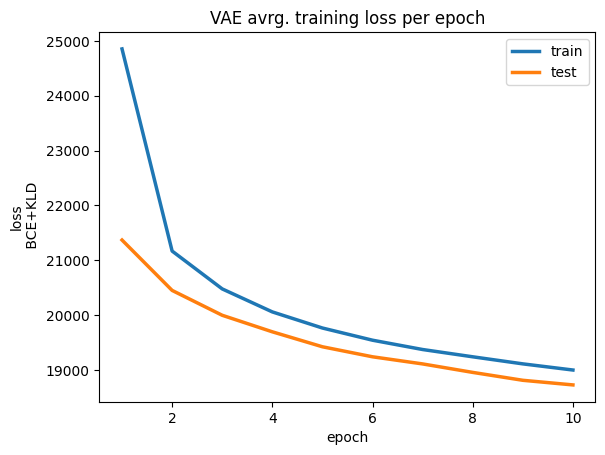

In [42]:
plot_losses(train_loss, test_loss, "loss_bernoulli.png")

# Continuous

In [43]:
model_continuous = VAE(hidden_dims=[300, 50, 2, 50, 300])
train_loss, test_loss = run_train_and_plot(model_continuous, continuous_loss)


Train epoch=1 [0/60000]	 loss=0.07818603515625
BCE=69705.78125 KLD=1.4169769287109375
Train epoch=1 [3200/60000]	 loss=-1043.75048828125
BCE=44483.59375 KLD=3540.4130859375
Train epoch=1 [6400/60000]	 loss=-1169.44775390625
BCE=39492.87109375 KLD=1275.3734130859375
Train epoch=1 [9600/60000]	 loss=-1201.68798828125
BCE=40265.44140625 KLD=1062.6270751953125
Train epoch=1 [12800/60000]	 loss=-1209.9244384765625
BCE=38874.59375 KLD=906.3953857421875
Train epoch=1 [16000/60000]	 loss=-1232.825439453125
BCE=36649.27734375 KLD=801.7705078125
Train epoch=1 [19200/60000]	 loss=-1232.22314453125
BCE=38201.3046875 KLD=758.58642578125
Train epoch=1 [22400/60000]	 loss=-1219.5438232421875
BCE=39122.80078125 KLD=630.1494750976562
Train epoch=1 [25600/60000]	 loss=-1251.00830078125
BCE=37585.21484375 KLD=658.2474365234375
Train epoch=1 [28800/60000]	 loss=-1291.130126953125
BCE=35090.765625 KLD=834.4527587890625
Train epoch=1 [32000/60000]	 loss=-1278.149658203125
BCE=35820.78515625 KLD=873.73828125

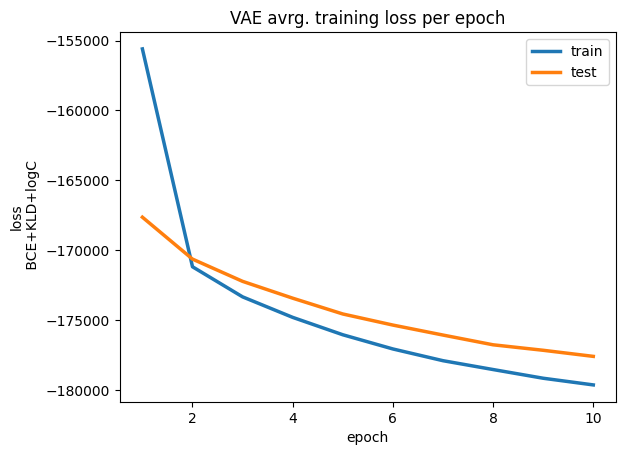

In [44]:
plot_losses(train_loss, test_loss, "loss_continuous.png", "BCE+KLD+logC")

# Beta

In [45]:
model_beta = BetaVAE(hidden_dims=[300, 50, 2, 50, 256, 300, 512])
train_loss, test_loss = run_train_and_plot(model_beta, beta_loss)

Train epoch=1 [0/60000]	 loss=-7285.04443359375
BCE=-932489.5 KLD=3.8429982662200928
Train epoch=1 [3200/60000]	 loss=-12918.0390625
BCE=-1653527.25 KLD=18.23374366760254
Train epoch=1 [6400/60000]	 loss=-13256.5224609375
BCE=-1696852.875 KLD=17.960525512695312
Train epoch=1 [9600/60000]	 loss=-13197.908203125
BCE=-1689347.875 KLD=15.643637657165527
Train epoch=1 [12800/60000]	 loss=-13015.244140625
BCE=-1665968.875 KLD=17.6426944732666
Train epoch=1 [16000/60000]	 loss=-13153.6787109375
BCE=-1683688.75 KLD=17.835615158081055
Train epoch=1 [19200/60000]	 loss=-13055.6318359375
BCE=-1671141.125 KLD=20.29745101928711
Train epoch=1 [22400/60000]	 loss=-12997.9072265625
BCE=-1663757.0 KLD=24.914445877075195
Train epoch=1 [25600/60000]	 loss=-13248.6181640625
BCE=-1695847.25 KLD=24.072298049926758
Train epoch=1 [28800/60000]	 loss=-13003.5712890625
BCE=-1664493.625 KLD=36.55913162231445
Train epoch=1 [32000/60000]	 loss=-13018.1591796875
BCE=-1666368.125 KLD=43.78251266479492
Train epoch=1 

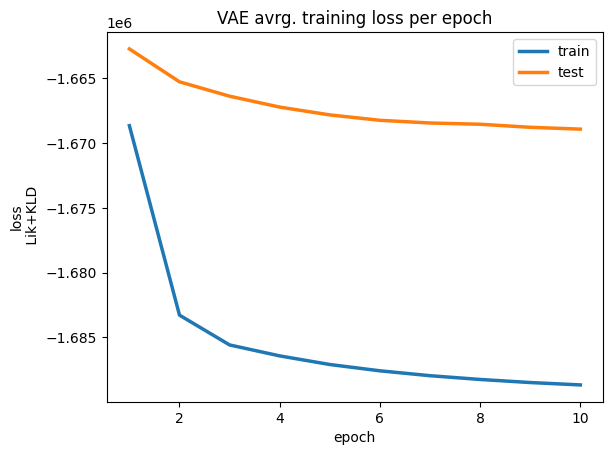

In [46]:
plot_losses(train_loss, test_loss, "loss_beta.png", "Lik+KLD")

# Ladder VAE

In [47]:
model_ladder = LadderVAE(hidden_dims=[300, 50, 256, 50, 300],
            encoder_dims= [
                (784, 784, 512, 256),
                (512, 256, 128, 128),
                (128, 64, 32, 64),
                (32, 16, 8, 32),
            ],
            ladder_dims=[
                (32, 2, 8, 64),
                (64, 16, 32, 128),
                (128, 64, 32, 256),
            ])
train_loss, test_loss = run_train_and_plot(model_ladder, ladder_loss)


Train epoch=1 [0/60000]	 loss=7.540876865386963
BCE=69666.3671875 KLD=199.85186767578125
Train epoch=1 [3200/60000]	 loss=-1137.781982421875
BCE=46012.75 KLD=957.4979248046875
Train epoch=1 [6400/60000]	 loss=-1214.3494873046875
BCE=39214.796875 KLD=553.4771728515625
Train epoch=1 [9600/60000]	 loss=-1228.984375
BCE=37439.875 KLD=541.4375
Train epoch=1 [12800/60000]	 loss=-1258.918701171875
BCE=37756.93359375 KLD=523.2132568359375
Train epoch=1 [16000/60000]	 loss=-1249.7763671875
BCE=40272.953125 KLD=507.83111572265625
Train epoch=1 [19200/60000]	 loss=-1269.2081298828125
BCE=38325.84375 KLD=460.5958251953125
Train epoch=1 [22400/60000]	 loss=-1313.340087890625
BCE=37151.546875 KLD=483.4994812011719
Train epoch=1 [25600/60000]	 loss=-1332.2603759765625
BCE=34135.421875 KLD=406.70330810546875
Train epoch=1 [28800/60000]	 loss=-1360.350341796875
BCE=32951.125 KLD=399.25787353515625
Train epoch=1 [32000/60000]	 loss=-1371.9486083984375
BCE=29989.341796875 KLD=357.912109375
Train epoch=1 

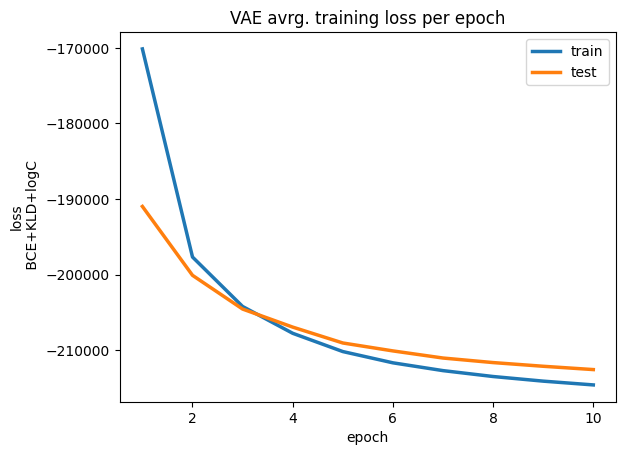

In [48]:
plot_losses(train_loss, test_loss, "loss_ladder.png", "BCE+KLD+logC")

# Measuring the difference

In [51]:
def extract_beta(x):
    alpha, beta = model_beta(x)[0]
    return alpha / (alpha + beta)

In [56]:
get_predictions_dict = {
    "Bernoulli": lambda x: model_bernoulli(x)[0],
    "Continuous": lambda x: model_continuous(x)[0],
    "Beta": extract_beta,
    "Ladder": lambda x: model_ladder(x)[0][0]
}

### Visualization

In [63]:
num = 50
fig, ax = plt.subplots(nrows = num, ncols = len(get_predictions_dict) + 1, figsize=(8,num), 
                       gridspec_kw = {'wspace':0.05, 'hspace':0, }, dpi = 1200)
with torch.no_grad():
    for i in range(num):
        img = torch.tensor(test_data[i])
        ax[i, 0].imshow(img.reshape(28, 28), cmap = "gray")
        for j, (name, model) in enumerate(get_predictions_dict.items()):
            if i == 0:
                ax[i, j + 1].set_title(name)
            ax[i, j + 1].imshow(model(img).reshape(28, 28), cmap = "gray")
ax[0, 0].set_title("Original")
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])

[]

### Square mean difference

In [57]:
sq_diffs = measure_sq_mean_diff([*get_predictions_dict.values()])

for name, diff in zip(get_predictions_dict, sq_diffs):
    print(f"{name}: {diff}")

Bernoulli: 0.04016776111291256
Continuous: 0.05094210636941716
Beta: 0.04521501353131607
Ladder: 0.012178867933142464


### Likelihoods

In [64]:
# Bernoulli
calc_likelihood(model_bernoulli, bernoulli_loss, 50)

-145.8535

In [65]:
# Continuous
calc_likelihood(model_continuous, continuous_loss, 50)

1407.6266

In [66]:
# Beta
calc_likelihood(model_beta, beta_loss, 50)

In [ ]:
# Ladder
calc_likelihood(model_ladder, ladder_loss, 50)

### Continuous ELBO

In [ ]:
# Bernoulli
np.mean(test(continuous_loss, model_bernoulli, test_loader=test_loader))

In [ ]:
# Continuous
np.mean(test(continuous_loss, model_continuous, test_loader=test_loader))

In [ ]:
# Beta
np.mean(test(continuous_loss, model_beta, test_loader=test_loader, 
             fn= lambda x: x[0] / (x[0] + x[1])))

In [ ]:
# Ladder
np.mean(test(continuous_loss, model_ladder, test_loader=test_loader, 
             fn= lambda x: x[0]))